## makemore: part 5

In [2]:
# Imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import time

NAMES_MALE = "../data/имена_српска_мушка.txt"
NAMES_FEMALE = "../data/имена_српска_женска.txt"

RESULTS_MALE = "../results/имена_српска_мушка_makemore_2003.txt"
RESULTS_FEMALE = "../results/имена_српска_женска_makemore_2003.txt"

In [3]:
# CONFIG VARIABLES
NAMES_FILE = NAMES_FEMALE
block_size = 3
embedding_dimensions = 10
neurons = 300
batch_size = 64
lr = 0.1

In [33]:
# read in all the words
with open(NAMES_FILE, 'r', encoding='utf-8') as f:
    words = f.read().splitlines()
# Convert the first letter of each word to lowercase
words = [word[0].lower() + word[1:] if word else word for word in words]
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(len(words))
print(max(len(w) for w in words))
print(words[:8])
vocab_size = len(stoi.keys())

2502
12
['агнежина', 'агнија', 'агница', 'бајка', 'бајна', 'баница', 'баша', 'бежана']


In [34]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([16528, 3]) torch.Size([16528])
torch.Size([2042, 3]) torch.Size([2042])
torch.Size([2054, 3]) torch.Size([2054])


In [35]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [36]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> п
..п --> р
.пр --> и
при --> п
рип --> е
ипе --> г
пег --> а
ега --> л
гал --> а
ала --> .
... --> в
..в --> у
.ву --> ј
вуј --> а
уја --> н
јан --> к
анк --> а
нка --> .
... --> ј
..ј --> е


In [37]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [38]:
torch.manual_seed(42); # seed rng for reproducibility

In [39]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, bias=False)
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12490


In [40]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 5000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  20000: 3.3657
   5000/  20000: 1.6936
  10000/  20000: 0.9850
  15000/  20000: 1.6783


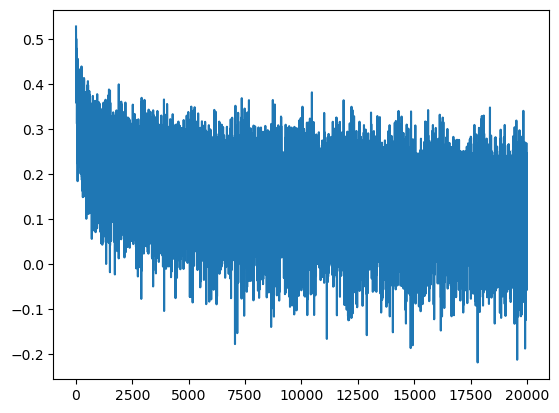

In [21]:
plt.plot(lossi)
# plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [43]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
  layer.training = False

In [44]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.2710174322128296
val 1.4610241651535034


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [46]:
num_of_names = 5
# Sample from the model
random_seed = int(time.time() * 1000) % (2**32)  # Ограничавамо на 32-битни опсег
g = torch.Generator().manual_seed(random_seed)

for _ in range(num_of_names):
    out = []
    context = [0] * block_size  # Initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        # print(emb)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        # print(x)
        for layer in layers:
          x = layer(x)
          # print(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # print(logits)
        # sample from the distribution
        # print(probs)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)

    # Rekonstruiši ime i promeni prvo slovo u veliko
    name = ''.join(itos[i] for i in out)
    name = name.capitalize()  # Pretvori prvo slovo u veliko

    print(name)

Свина
Дутовина
Радина
Озрена
Радуна


### Next time:
Why convolutions? Brief preview/hint